In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pandas import *
import torch
import torch.nn as nn
from torch.autograd import Variable

the data we create is composed of three cosine functions superimposed


In [3]:
def normalizeAB(a, b, x):
    minX = x.min()
    maxX = x.max()
    return (b - a) * ((x - minX) / (maxX - minX)) + a

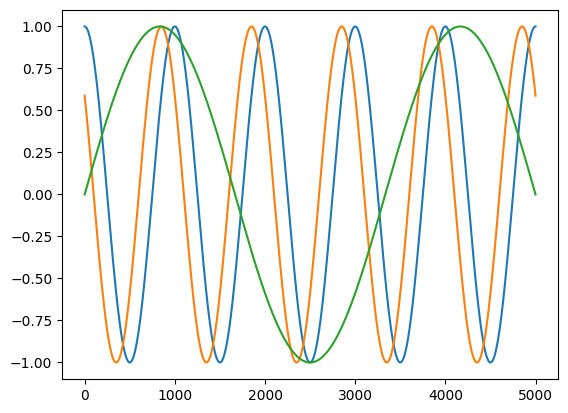

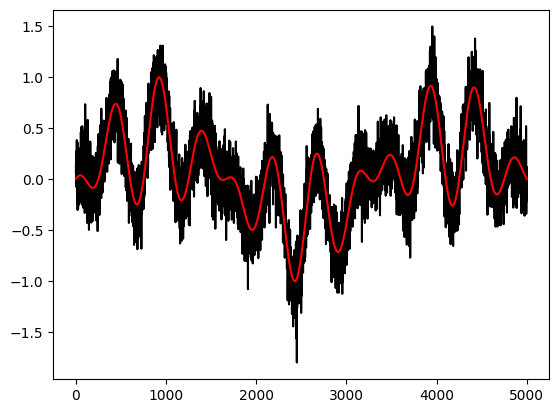

In [4]:
x = linspace(0, numpy.pi * 10, 5001)
A = numpy.cos(x)
B = numpy.cos(x + numpy.pi * 0.3)
C = numpy.cos((x + numpy.pi * 5) * 0.3)
plot(A)
plot(B)
plot(C)
figure()
rawData = normalizeAB(-1, 1, A * B * C)
noise = numpy.random.normal(0, 0.2, 5001)
data = rawData + noise
plot(data, "k")
plot(rawData, "r")

consider the first 3000 datapoints training data and the remaining 2000 test data


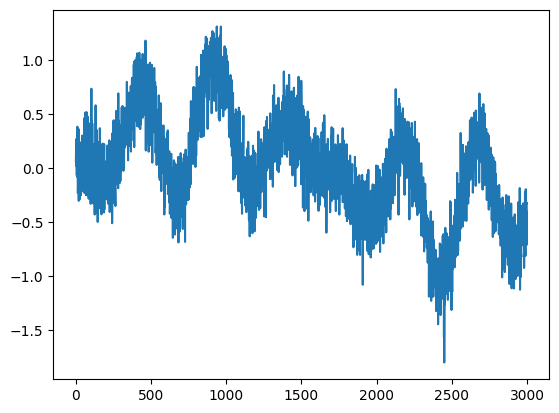

In [5]:
train_data = data[:3000]
test_data = data[3000:]

train_data, test_data
train_data_normalized = train_data
test_data_normalized = test_data
plot(train_data_normalized)

Consult code along 14 for RNN and LSTM support, implement your RNN and your LSTM


Take the "data" variable (defined above) and create four different training sets that differ in length (3,30,100,300)


In [9]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L - tw):
        train_seq = input_data[i : i + tw]
        train_label = input_data[i + tw : i + tw + 1]
        inout_seq.append((train_seq.flatten(), train_label))
    return inout_seq


train_window_3 = 3
train_window_30 = 30
train_window_100 = 100
train_window_300 = 300

train_inout_seq_3 = create_inout_sequences(train_data_normalized, train_window_3)
train_inout_seq_30 = create_inout_sequences(train_data_normalized, train_window_30)
train_inout_seq_100 = create_inout_sequences(train_data_normalized, train_window_100)
train_inout_seq_300 = create_inout_sequences(train_data_normalized, train_window_300)

test_inout_seq_3 = create_inout_sequences(test_data_normalized, train_window_3)
test_inout_seq_30 = create_inout_sequences(test_data_normalized, train_window_30)
test_inout_seq_100 = create_inout_sequences(test_data_normalized, train_window_100)
test_inout_seq_300 = create_inout_sequences(test_data_normalized, train_window_300)

Now train an RNN on those four different datasets, remember we use the first 3000 datapoints as training data
after training, plot the test accuracy and training accuracy for all datapoints


In [12]:
# RNN
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(RNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        nr_of_layers_in_rnn = 1

        self.rnn = nn.RNN(
            input_size,
            self.hidden_layer_size,
            nr_of_layers_in_rnn,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h0 = torch.zeros(1, 1, self.hidden_layer_size)
        rnn_out, h0 = self.rnn(input_seq, h0)
        out = self.linear(rnn_out)
        return out[0][-1]


model = RNN()
print(model)
print(train_inout_seq_3[0][0], train_inout_seq_3[0][1])
sequence = torch.Tensor(train_inout_seq_3[0][0].reshape(1, train_window_3, 1))
out = model(sequence)
print()
print(sequence.shape, out.shape)

RNN(
  (rnn): RNN(1, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
[0.06559105 0.15394623 0.08791245] [0.01971722]

torch.Size([1, 3, 1]) torch.Size([1])


In [37]:
# LSTM
class OurLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(OurLSTM,self).__init__()
        self.hidden_layer_size=hidden_layer_size
        nr_of_layers_in_lstm=1
        
        self.lstm=nn.LSTM(input_size,self.hidden_layer_size,nr_of_layers_in_lstm,
                        batch_first=True)
        
        self.linear = nn.Linear(hidden_layer_size,output_size)
        
    def forward(self,input_seq):
        h0= (torch.zeros(1,1,self.hidden_layer_size),
             torch.zeros(1,1,self.hidden_layer_size))
        lstm_out,h0 = self.lstm(input_seq,h0)
        out=self.linear(lstm_out)
        return out[0][-1]
    
model=OurLSTM()
print(model)
print(train_inout_seq_3[0][0], train_inout_seq_3[0][1])
sequence = torch.Tensor(train_inout_seq_3[0][0].reshape(1, train_window_3, 1))
out = model(sequence)
print()
print(sequence.shape, out.shape)

OurLSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
[0.06559105 0.15394623 0.08791245] [0.01971722]

torch.Size([1, 3, 1]) torch.Size([1])


Window 3, Epoch 0 - Training Loss: 0.103484, Test Loss: 0.126319
Window 3, Epoch 2 - Training Loss: 0.051646, Test Loss: 0.058732
Window 3, Epoch 4 - Training Loss: 0.051171, Test Loss: 0.057724
Window 3, Epoch 6 - Training Loss: 0.050914, Test Loss: 0.057164
Window 3, Epoch 8 - Training Loss: 0.050746, Test Loss: 0.056754


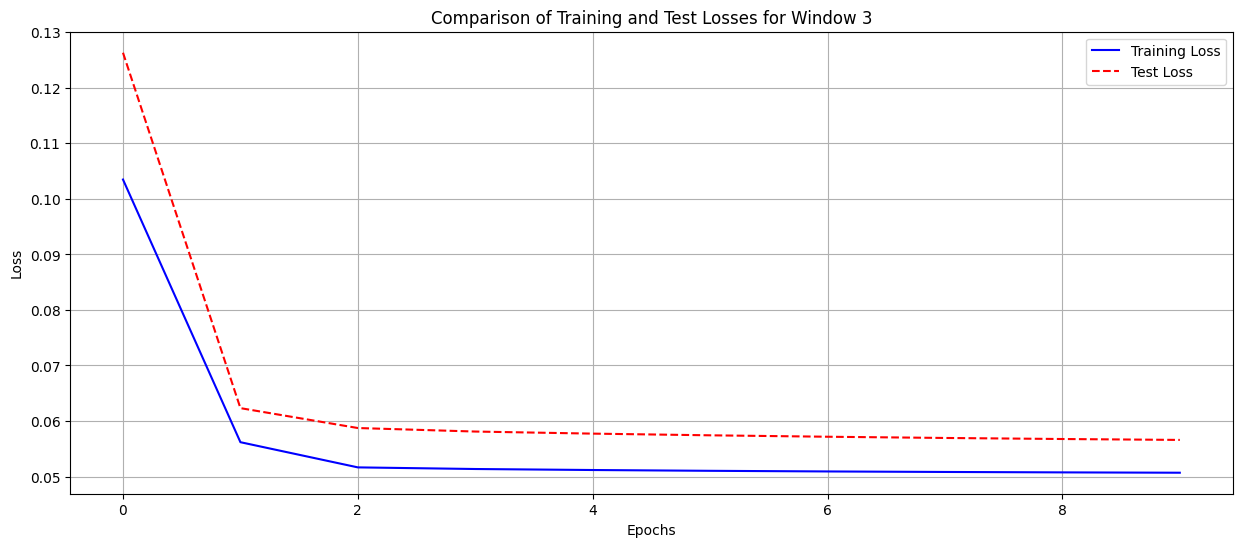

Window 30, Epoch 0 - Training Loss: 0.085264, Test Loss: 0.073152
Window 30, Epoch 2 - Training Loss: 0.044195, Test Loss: 0.054016
Window 30, Epoch 4 - Training Loss: 0.043958, Test Loss: 0.052660
Window 30, Epoch 6 - Training Loss: 0.043851, Test Loss: 0.051955
Window 30, Epoch 8 - Training Loss: 0.043791, Test Loss: 0.051524


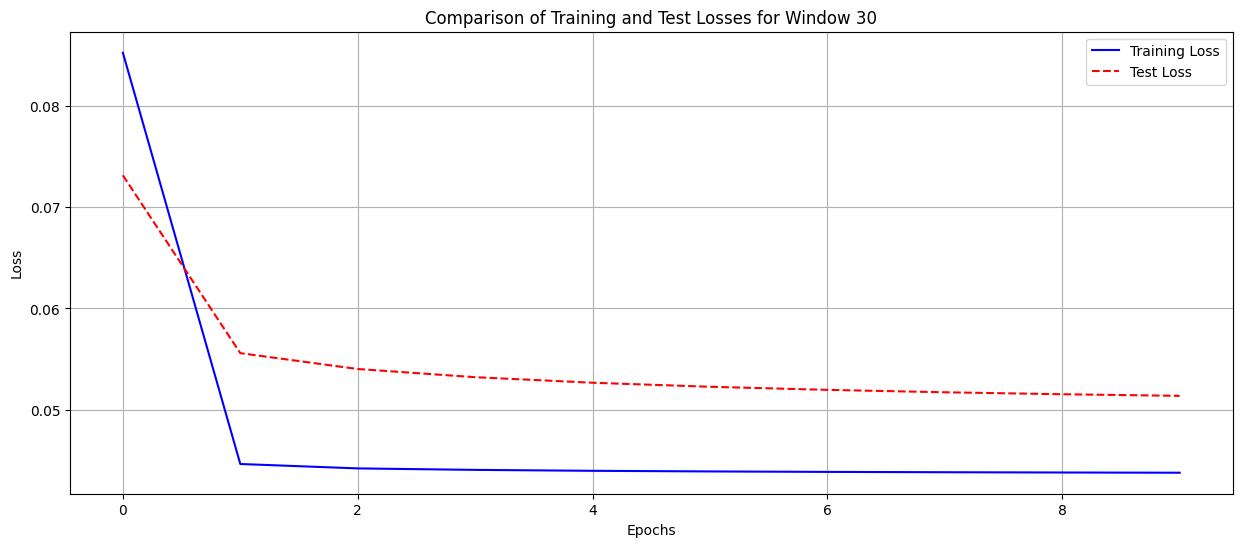

Window 100, Epoch 0 - Training Loss: 0.103150, Test Loss: 0.097955
Window 100, Epoch 2 - Training Loss: 0.044087, Test Loss: 0.053274
Window 100, Epoch 4 - Training Loss: 0.043840, Test Loss: 0.051528
Window 100, Epoch 6 - Training Loss: 0.043730, Test Loss: 0.050647


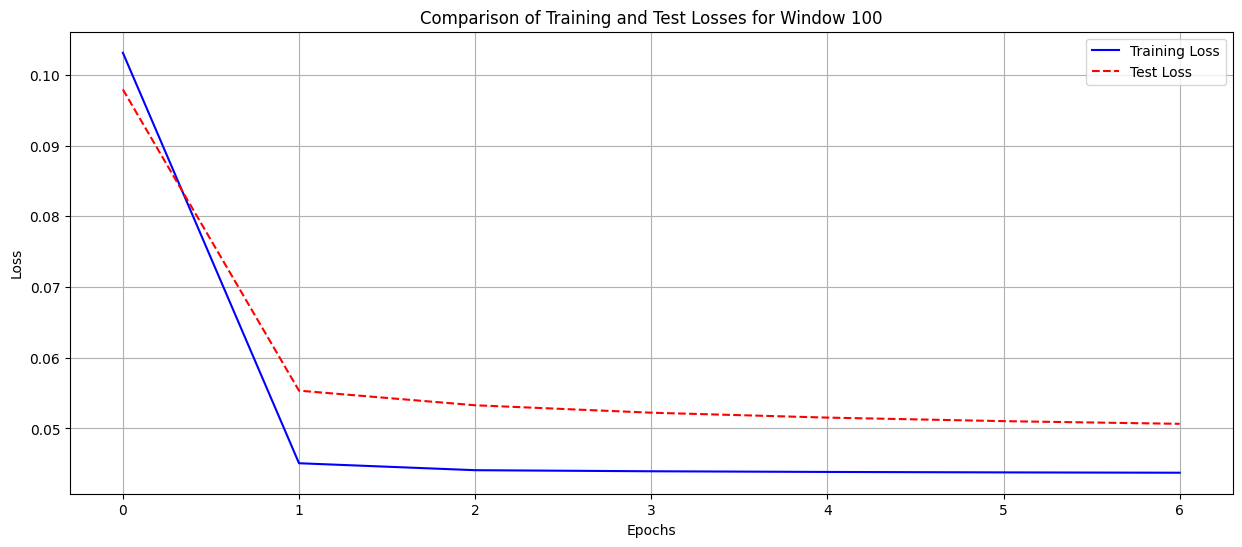

Window 300, Epoch 0 - Training Loss: 0.096952, Test Loss: 0.060479
Window 300, Epoch 2 - Training Loss: 0.043745, Test Loss: 0.052106
Window 300, Epoch 4 - Training Loss: 0.043417, Test Loss: 0.050786


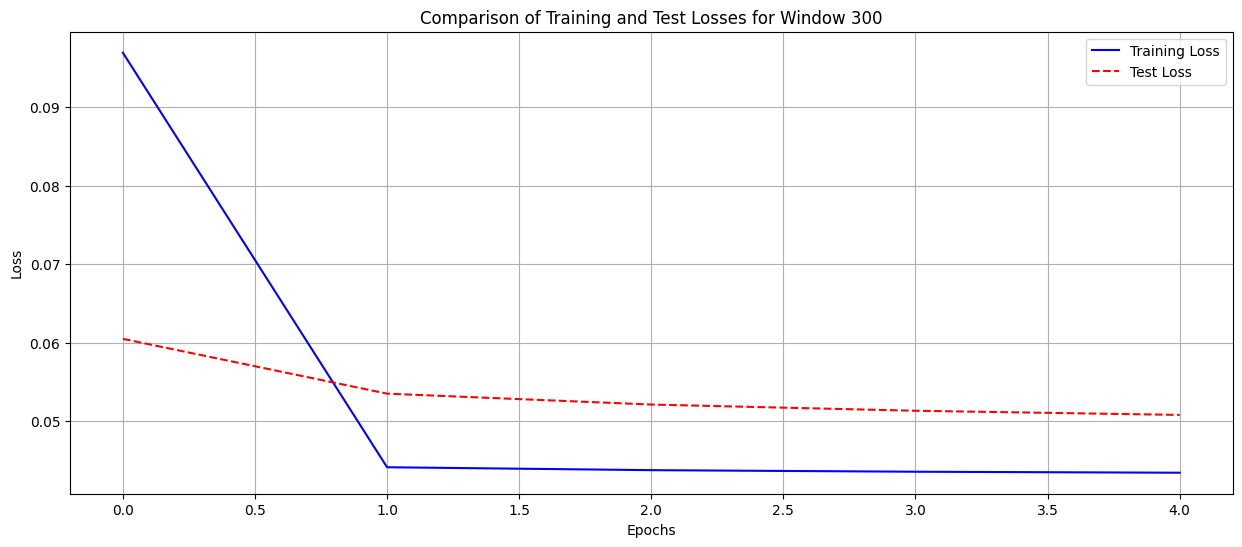

In [49]:


def train_one_epoch(model, train_data, optimizer, loss_function, train_window):
    running_loss = 0
    model.train()
    
    for seq, labels in train_data:
        optimizer.zero_grad()
        y_pred = model(torch.Tensor(seq.reshape(1, train_window, 1)))
        loss = loss_function(y_pred, torch.Tensor(labels))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    return running_loss / len(train_data)

def test_one_epoch(model, test_data, loss_function, train_window):
    test_loss = 0
    model.eval()
    
    with torch.no_grad():
        for seq, labels in test_data:
            y_pred = model(torch.Tensor(seq.reshape(1, train_window, 1)))
            loss = loss_function(y_pred, torch.Tensor(labels))
            test_loss += loss.item()
            
    return test_loss / len(test_data)


def train_model_for_window_size(model,window_size, epochs, data_dict,optimizer,loss_function):
    train_data = data_dict[window_size]["train"]
    test_data = data_dict[window_size]["test"]
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        avg_train_loss = train_one_epoch(model, train_data, optimizer, loss_function, window_size)
        avg_test_loss = test_one_epoch(model, test_data, loss_function, window_size)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        if epoch % 2 == 0: 
            print(f"Window {window_size}, Epoch {epoch} - Training Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
    
    plt.figure(figsize=(15, 6))
    plt.plot(train_losses, label="Training Loss", color="blue")
    plt.plot(test_losses, label="Test Loss", color="red", linestyle="dashed")
    plt.title(f"Comparison of Training and Test Losses for Window {window_size}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

data_dict = {
    3: {
        "train": train_inout_seq_3,
        "test": test_inout_seq_3,
        "epochs" : 10,
        "lr" : 0.00001
    },
    30: {
        "train": train_inout_seq_30,
        "test": test_inout_seq_30,
        "epochs" : 10,
        "lr" : 0.00001
    },
    100: {
        "train": train_inout_seq_100,
        "test": test_inout_seq_100,
        "epochs" : 7,
        "lr" : 0.00001
    },
    300: {
        "train": train_inout_seq_300,
        "test": test_inout_seq_300,
        "epochs" : 5,
        "lr" : 0.00001
    }
}

model_rnn = None
for window_size in data_dict.keys():
    learning_rate =  data_dict[window_size]["lr"]
    model = RNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epochs = data_dict[window_size]["epochs"]
    loss_function = torch.nn.MSELoss()  
    train_model_for_window_size(model,window_size, epochs, data_dict, optimizer,loss_function)
    model_rnn = model

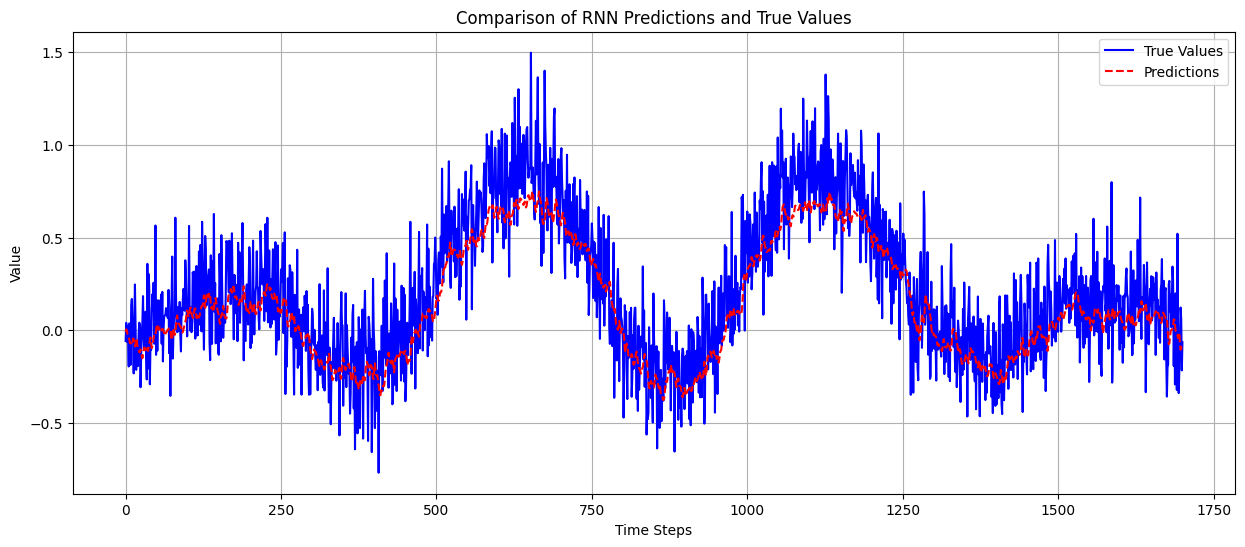

In [65]:
model_rnn.eval()
predictions = []

with torch.no_grad():
    for seq, true_val in test_inout_seq_300:
        seq_tensor = torch.Tensor(seq.reshape(1, train_window_300, 1))
        predicted_val = model_rnn(seq_tensor)
        predictions.append(predicted_val.item())

actual_values = [label[0] for _, label in test_inout_seq_300]

plt.figure(figsize=(15, 6))
plt.plot(actual_values, label="True Values", color="blue")
plt.plot(predictions, label="Predictions", color="red", linestyle="dashed")
plt.title("Comparison of RNN Predictions and True Values")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

Now train an LSTM on those four different datasets, remember we use the first 3000 datapoints as training data
after training, plot the test accuracy and training accuracy for all datapoints


Window 3, Epoch 0 - Training Loss: 0.209550, Test Loss: 0.172144
Window 3, Epoch 2 - Training Loss: 0.099957, Test Loss: 0.081520
Window 3, Epoch 4 - Training Loss: 0.052219, Test Loss: 0.054967
Window 3, Epoch 6 - Training Loss: 0.051584, Test Loss: 0.054307
Window 3, Epoch 8 - Training Loss: 0.051415, Test Loss: 0.054074


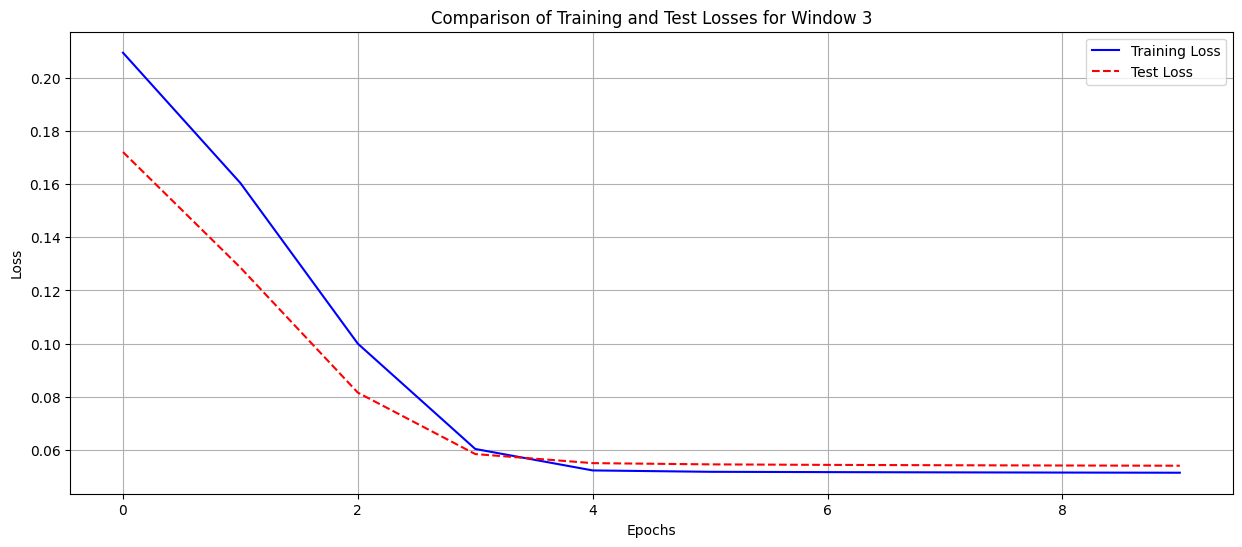

Window 30, Epoch 0 - Training Loss: 0.172871, Test Loss: 0.157315
Window 30, Epoch 2 - Training Loss: 0.043750, Test Loss: 0.047302
Window 30, Epoch 4 - Training Loss: 0.043645, Test Loss: 0.047121
Window 30, Epoch 6 - Training Loss: 0.043546, Test Loss: 0.046767
Window 30, Epoch 8 - Training Loss: 0.043473, Test Loss: 0.046484


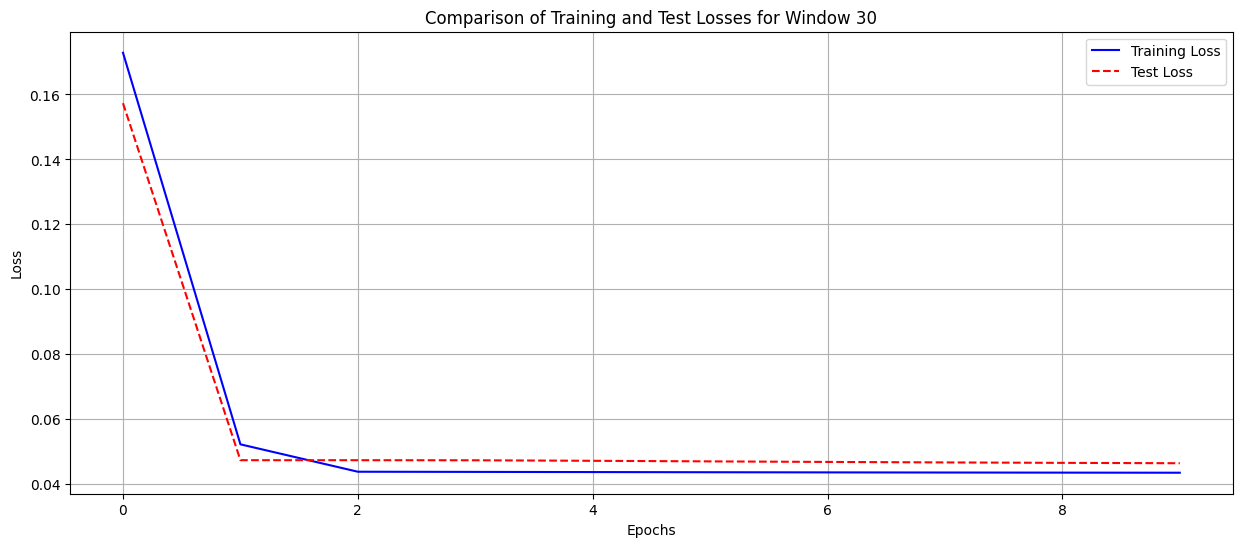

Window 100, Epoch 0 - Training Loss: 0.155721, Test Loss: 0.158031
Window 100, Epoch 2 - Training Loss: 0.044243, Test Loss: 0.049260
Window 100, Epoch 4 - Training Loss: 0.043963, Test Loss: 0.048520
Window 100, Epoch 6 - Training Loss: 0.043756, Test Loss: 0.047831


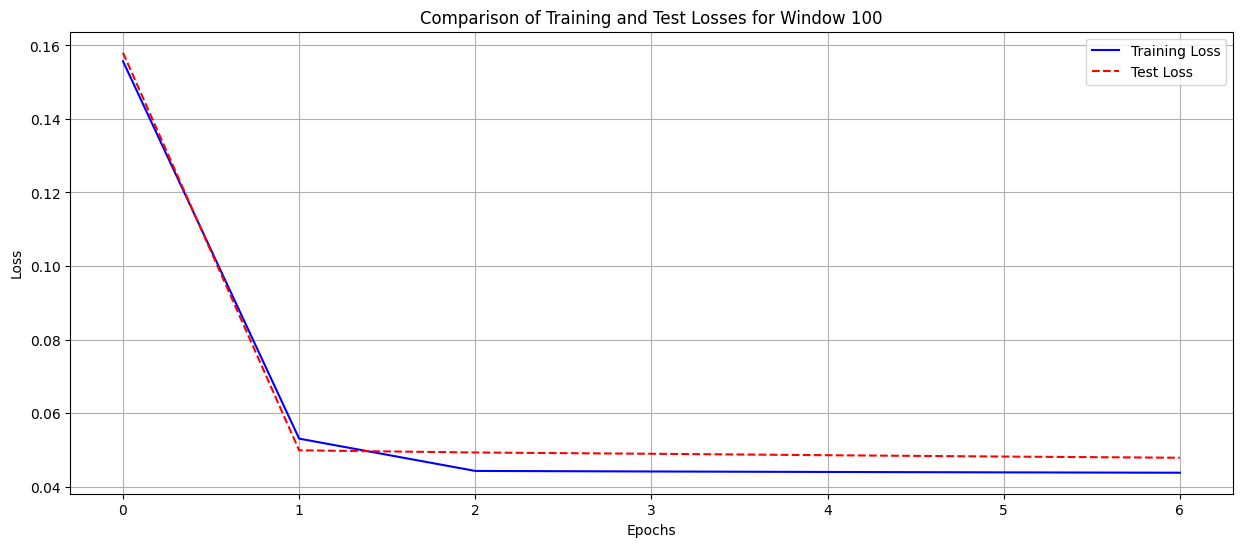

Window 300, Epoch 0 - Training Loss: 0.190239, Test Loss: 0.196717
Window 300, Epoch 2 - Training Loss: 0.044065, Test Loss: 0.050434
Window 300, Epoch 4 - Training Loss: 0.043779, Test Loss: 0.050033


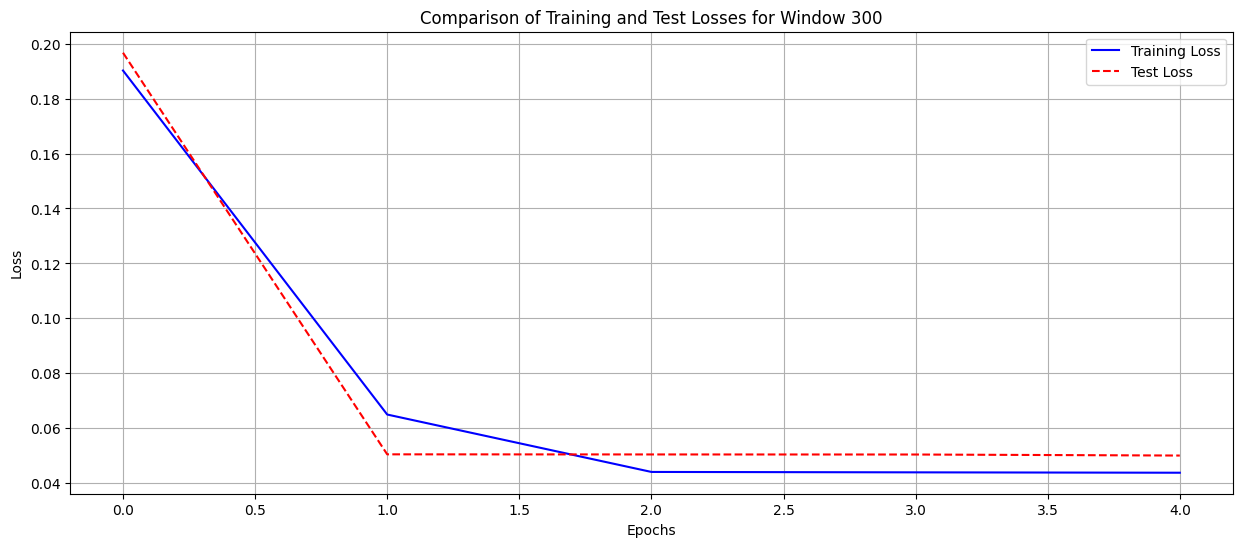

In [50]:

data_dict = {
    3: {
        "train": train_inout_seq_3,
        "test": test_inout_seq_3,
        "epochs" : 10,
        "lr" : 0.00001
    },
    30: {
        "train": train_inout_seq_30,
        "test": test_inout_seq_30,
        "epochs" : 10,
        "lr" : 0.00001
    },
    100: {
        "train": train_inout_seq_100,
        "test": test_inout_seq_100,
        "epochs" : 7,
        "lr" : 0.00001
    },
    300: {
        "train": train_inout_seq_300,
        "test": test_inout_seq_300,
        "epochs" : 5,
        "lr" : 0.00001
    }
}

model_lstm = None
for window_size in data_dict.keys():
    learning_rate =  data_dict[window_size]["lr"]
    model = OurLSTM()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epochs = data_dict[window_size]["epochs"]
    loss_function = torch.nn.MSELoss()  
    train_model_for_window_size(model,window_size, epochs, data_dict, optimizer,loss_function)
    model_lstm = model

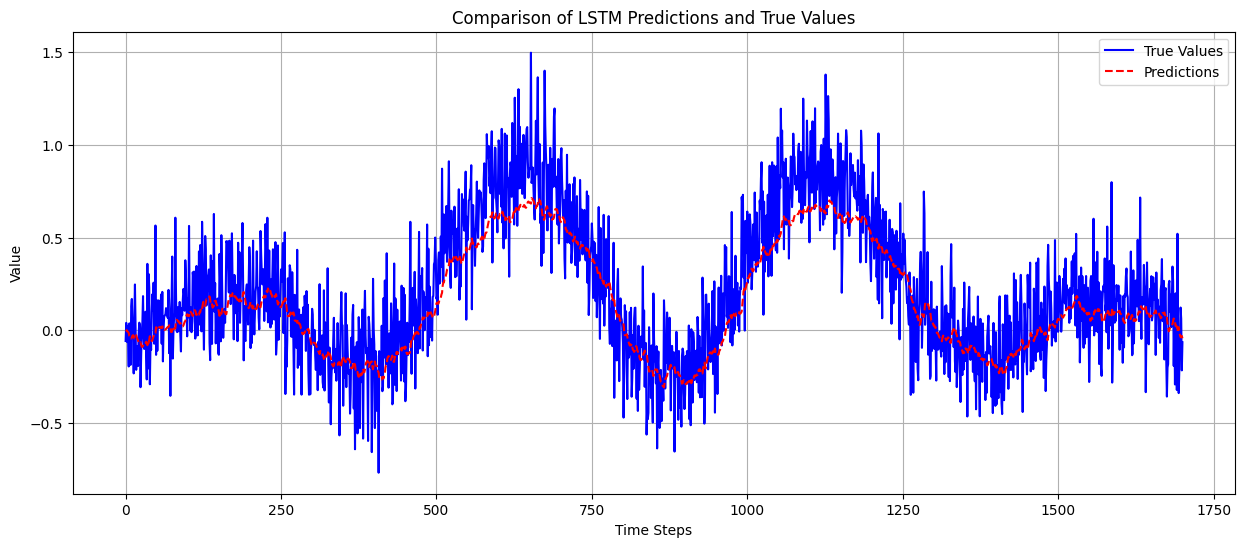

In [67]:
model_lstm.eval()
predictions = []

with torch.no_grad():
    for seq, true_val in test_inout_seq_300:
        seq_tensor = torch.Tensor(seq.reshape(1, train_window_300, 1))
        predicted_val = model_lstm(seq_tensor)
        predictions.append(predicted_val.item())

actual_values = [label[0] for _, label in test_inout_seq_300]

plt.figure(figsize=(15, 6))
plt.plot(actual_values, label="True Values", color="blue")
plt.plot(predictions, label="Predictions", color="red", linestyle="dashed")
plt.title("Comparison of LSTM Predictions and True Values")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

take that last trained RNN (for 300 datapoints) and the last LSTM, determine the next 5000 datapoints by feeding the output of the RNN (or LSTM) back into the model, plot the predictions


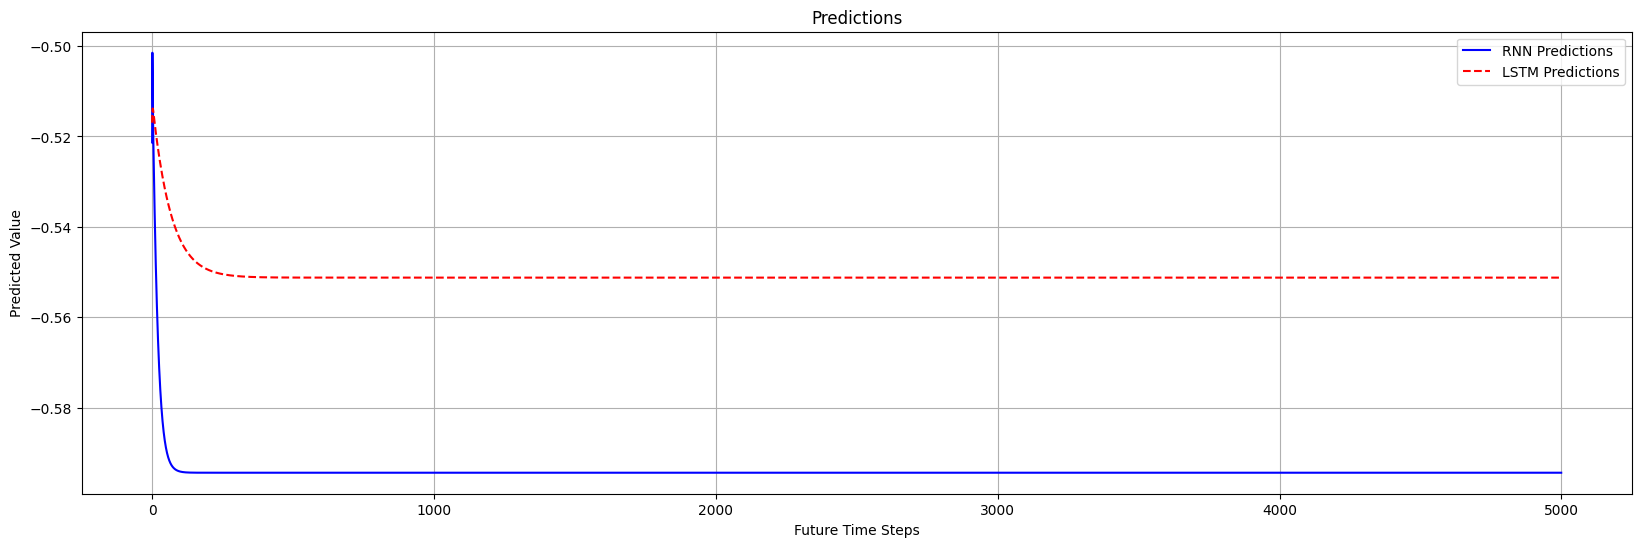

predictions_rnn [-0.521316647529602, -0.5014757513999939, -0.5084315538406372, -0.5177250504493713, -0.5196706056594849, -0.5227674841880798, -0.5266293883323669, -0.5303025245666504, -0.5336399078369141, -0.5367586016654968, -0.5398451685905457, -0.5428085923194885, -0.5455757975578308, -0.5482155680656433, -0.5507277846336365, -0.5531154274940491, -0.5553842186927795, -0.5575360059738159, -0.5595772862434387, -0.5615131258964539, -0.5633479356765747, -0.5650863647460938, -0.5667327046394348, -0.5682913064956665, -0.5697664022445679, -0.5711618661880493, -0.5724816918373108, -0.5737296342849731, -0.5749091506004333, -0.5760237574577332, -0.5770768523216248, -0.5780715346336365, -0.5790107250213623, -0.5798974633216858, -0.580734372138977, -0.5815242528915405, -0.582269549369812, -0.5829726457595825, -0.5836358070373535, -0.5842613577842712, -0.584851086139679, -0.5854071378707886, -0.5859313607215881, -0.5864254832267761, -0.5868911743164062, -0.5873300433158875, -0.5877435803413391, 

In [62]:
def predict_future(model, initial_sequence, future_length, window_size):
    predictions = []
    
    input_sequence = initial_sequence
    
    model.eval()
    with torch.no_grad():
        for i in range(future_length):
            predicted_value = model(torch.Tensor(input_sequence.reshape(1, window_size, 1)))
            
            predictions.append(predicted_value.item())
            
            input_sequence = np.roll(input_sequence, -1) 
            input_sequence[-1] = predicted_value.item()  
    
    return predictions

initial_sequence_rnn = train_data_normalized[-train_window_300:]
predictions_rnn = predict_future(model_rnn, initial_sequence_rnn, 5000, train_window_300)



initial_sequence_lstm = train_data_normalized[-train_window_300:]
predictions_lstm = predict_future(model_lstm, initial_sequence_lstm, 5000, train_window_300)

plt.figure(figsize=(20, 6))
plt.plot(predictions_rnn, label="RNN Predictions", color="blue")
plt.plot(predictions_lstm, label="LSTM Predictions", color="red", linestyle="dashed")
plt.title("Predictions")
plt.xlabel("Future Time Steps")
plt.ylabel("Predicted Value")
plt.legend()
plt.grid(True)
plt.show()

print("predictions_rnn",predictions_rnn)
print("predictions_lstm",predictions_lstm)


Which of the two models RNN or LSTM has a better prediction horizon? Write your answer as a couple of sentences, and give the reasons for your interpretation


LSTM (Long Short-Term Memory) has a better prediction horizon compared to RNN (Recurrent Neural Network). The primary reason for this is the LSTM's capability to remember long-term dependencies, thanks to its gating mechanisms, which allow it to learn and remember information over longer sequences. In contrast, RNNs struggle with vanishing and exploding gradient problems, which make them less effective at capturing long-term dependencies in data. As a result, for tasks that require considering long-range context or information, LSTMs tend to outperform RNNs.